# Yolov5x

YOLO refers to “You Only Look Once” is one of the most versatile and famous object detection models. For every real-time object detection work.

For this model, we used the generated PNG images to generate new JPG images, due to the inputs of Yolo model. For Yolov5, the images must not be in .png format. And labels have to be in .txt format. The txt file contains classes and coordinates of the bounding boxes.

## About Yolov5

YOLOv5 got released Utralytics. It is publicly released on Github. Utralytics introduced the YOLOv5 Pytorch based approach, and Yes! YOLOv5 is written in the Pytorch framework.That's why it is super fast. And it comes with some default augmentation technique, which makes help it to converge it toward accuracy

[Read more about Yolov5 here](https://github.com/ultralytics/yolov5)

![yolov5](https://programmerclick.com/images/648/88e36f52a6f2fe9ca290f9bf272f7cd0.png "YoloV5")

## Yolov5 - Generate Model

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
print(torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else CPU)

1.10.0+cu102 _CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4040MB, multi_processor_count=6)


In [2]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

### Get Yolov5 from repo

Clone the Yolov5 repo from here & install its requirements: https://github.com/ultralytics/yolov5.git

In [3]:
# Cloning the repo and installing requiements
!git clone https://github.com/ultralytics/yolov5.git
!mv ./yolov5/* ./
!pip install -r requirements.txt
clear_output()

### Data preparation for Yolov5

In [4]:
# Copying the dataset to working directory
!mkdir dataset
!cp ./yolov5-data/* -r ./dataset
clear_output()

In [5]:
len(os.listdir('./dataset/covid19/images/'))

4294

In [6]:
%%writetemplate ./split_dataset.py

from utils.datasets import *
autosplit('./dataset/covid19', weights=(0.8, 0.2, 0.0))

In [7]:
!python3 ./split_dataset.py

Autosplitting images from dataset/covid19
100%|████████████████████████████████████| 4294/4294 [00:00<00:00, 17508.58it/s]


Now, create a directory named **/datafile**

In [8]:
!mkdir datafile
clear_output()

### Defining the dataset

In [9]:
%%writetemplate ./datafile/data.yaml

train: ./dataset/autosplit_train.txt
val: ./dataset/autosplit_val.txt

nc: 4
names: ['Negative for Pneumonia', 'Typical Appearance',
        'Indeterminate Appearance', 'Atypical Appearance']

### Model Params

In [10]:
%%writetemplate ./models/custom_yolov5x.yaml


# parameters
nc: 4  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Yolov5 - Model training

In [13]:
# torch.cuda.empty_cache()

In [14]:
%%time

!python3 train.py --img-size 128 --batch-size 2 --epochs 40 --data './datafile/data.yaml' --cfg ./models/custom_yolov5x.yaml --weights yolov5x.pt --name experiment2 --cache

train: weights=yolov5x.pt, cfg=./models/custom_yolov5x.yaml, data=./datafile/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=40, batch_size=2, imgsz=128, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=experiment2, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 c497687 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4040MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gam

### Analyzing results

In [15]:
os.listdir('./runs/train/experiment217/')

['val_batch1_labels.jpg',
 'P_curve.png',
 'weights',
 'results.csv',
 'F1_curve.png',
 'opt.yaml',
 'val_batch0_labels.jpg',
 'labels_correlogram.jpg',
 'hyp.yaml',
 'val_batch1_pred.jpg',
 'train_batch1.jpg',
 'train_batch0.jpg',
 'results.png',
 'train_batch2.jpg',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg',
 'R_curve.png',
 'confusion_matrix.png',
 'PR_curve.png',
 'val_batch0_pred.jpg',
 'labels.jpg',
 'events.out.tfevents.1636954449.pop-os.7089.0']

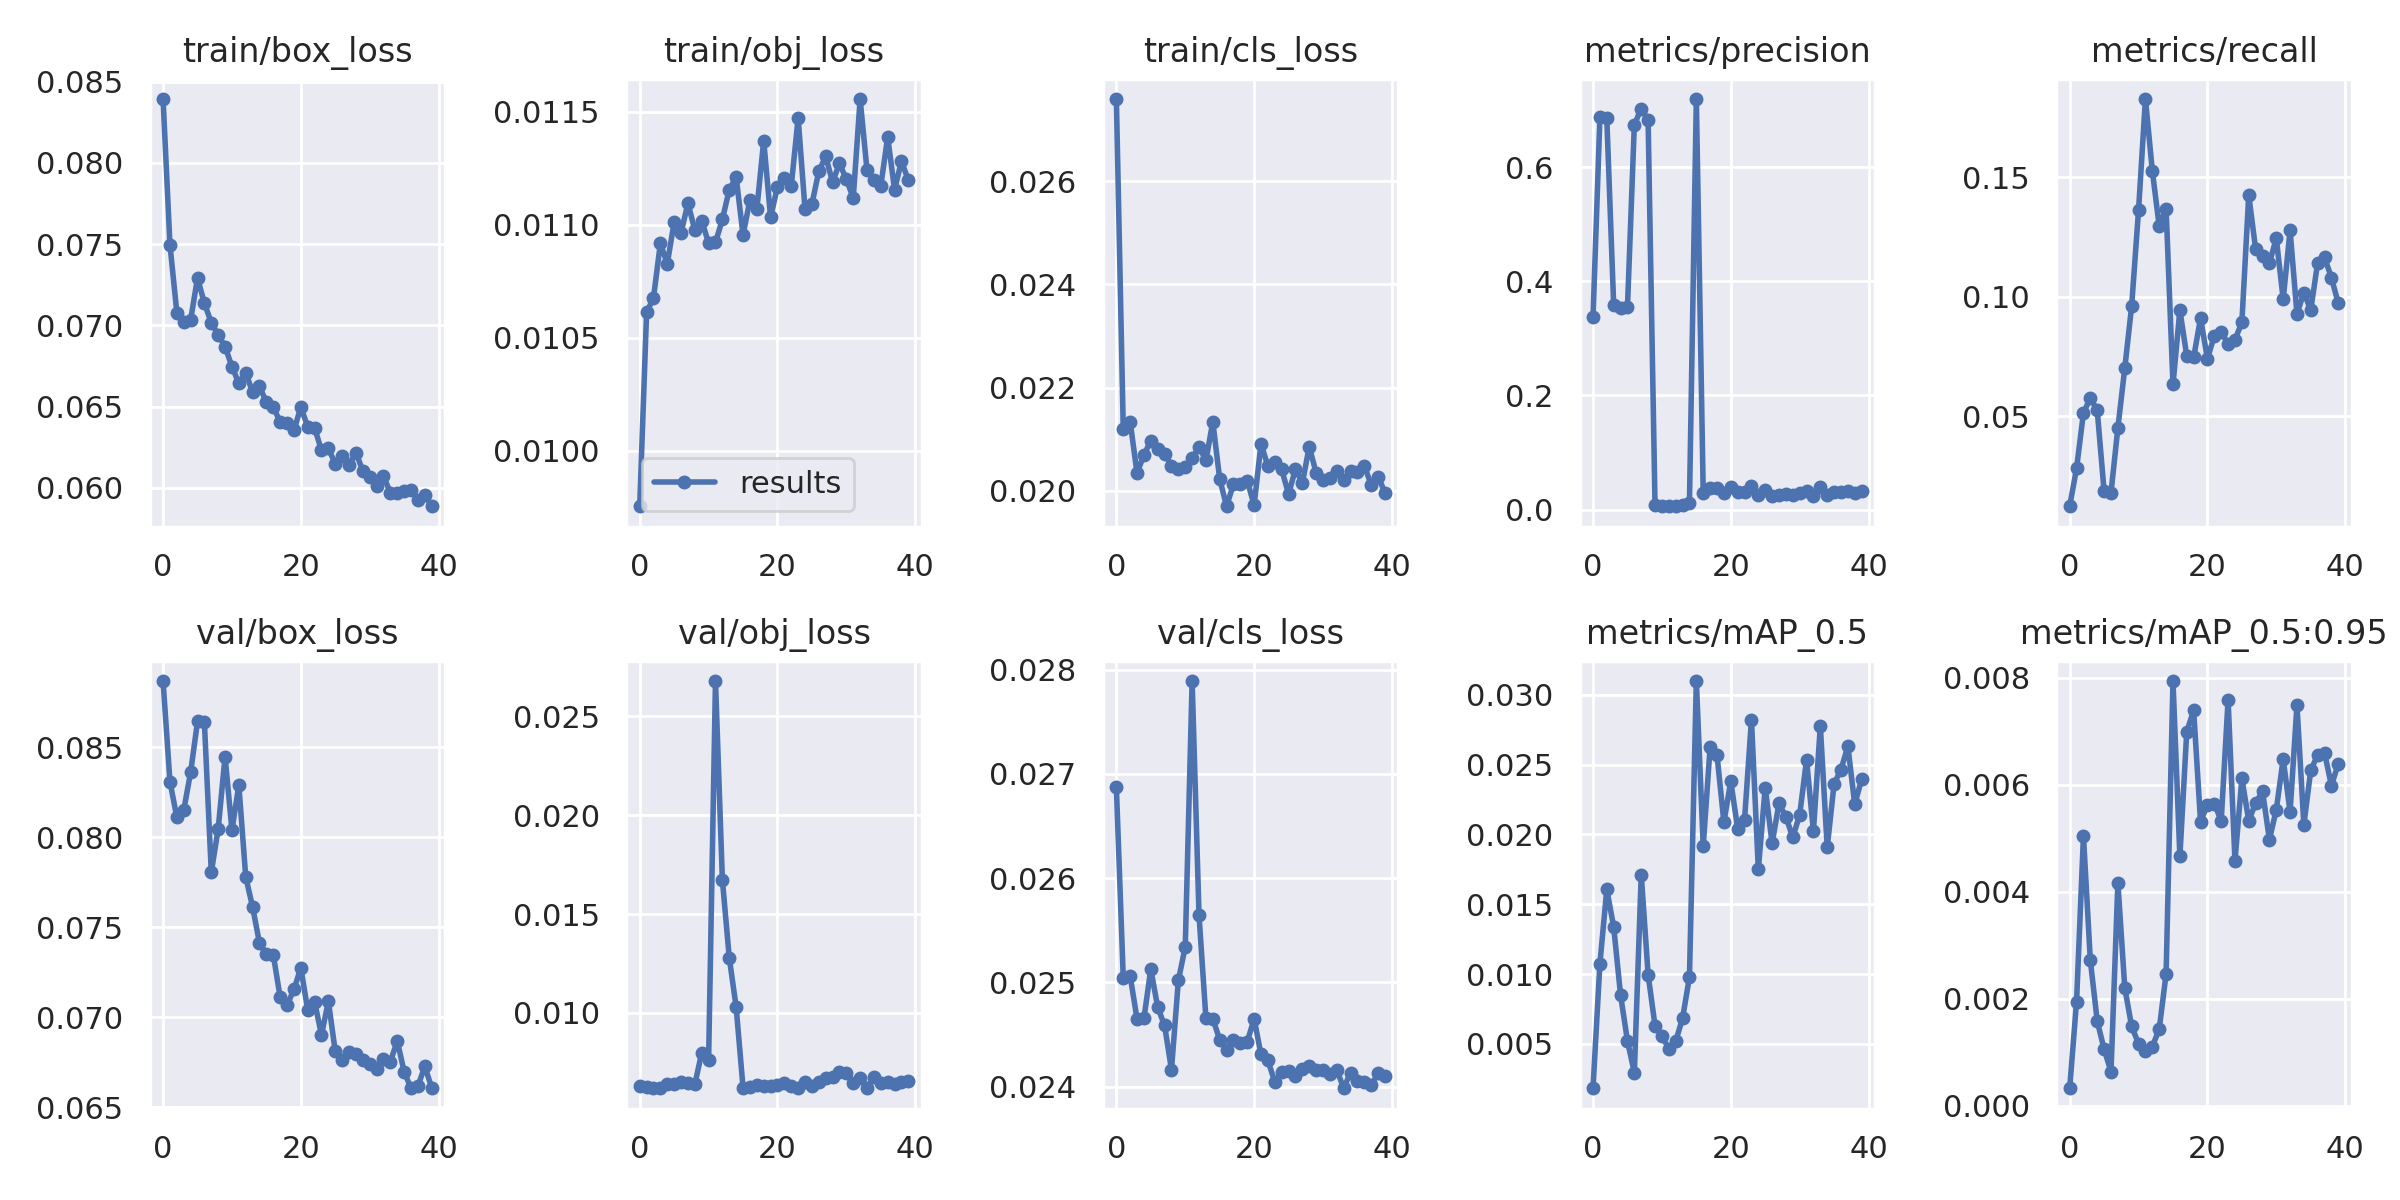

In [16]:
Image('./runs/train/experiment217/results.png')

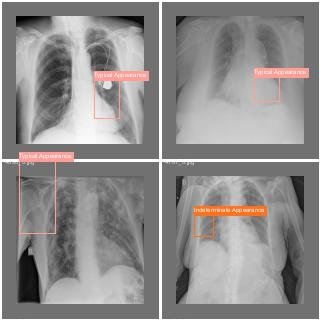

In [17]:
Image('./runs/train/experiment217/val_batch1_labels.jpg')

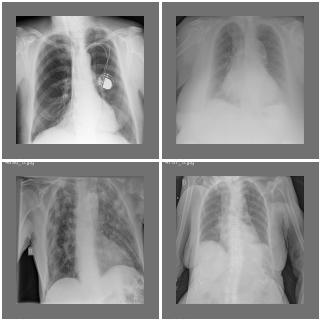

In [18]:
Image('./runs/train/experiment217/val_batch1_pred.jpg')

In [21]:
!python detect.py --img-size 512  --conf 0.1 --source ./yolov5-data/covid19/images/1000_0.jpg --weights ./runs/train/experiment217/weights/best.pt

detect: weights=['./runs/train/experiment217/weights/best.pt'], source=./yolov5-data/covid19/images/1000_0.jpg, imgsz=[512, 512], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 c497687 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4040MiB)

Fusing layers... 
Model Summary: 476 layers, 87218881 parameters, 0 gradients, 217.2 GFLOPs
image 1/1 /home/gusmendez99/Documents/DataScience/SIIM-Project/models/yolov5/yolov5-data/covid19/images/1000_0.jpg: 512x512 6 Typical Appearances, Done. (0.548s)
Speed: 1.0ms pre-process, 547.9ms inference, 4.4ms NMS per image at shape (1, 3, 512, 512)
Results saved to runs/detect/exp3


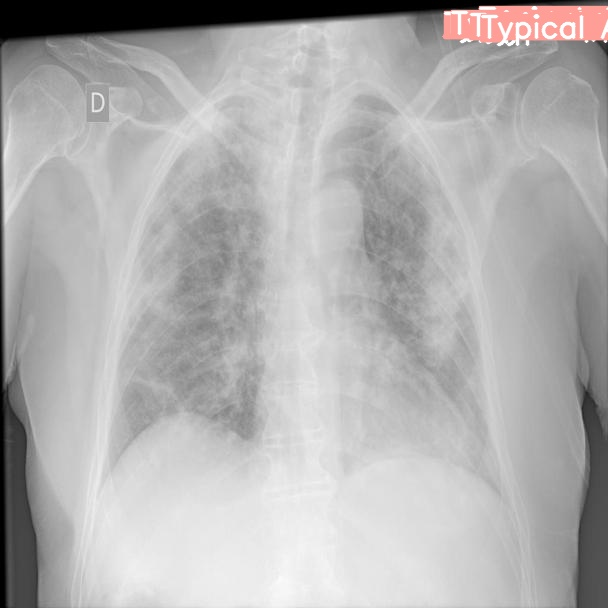

In [22]:
Image('./runs/detect/exp3/1000_0.jpg')